In [39]:
import math

# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return math.sqrt(distance)
 
# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors
 
# Make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction
 
# naive kNN 
def k_nearest_neighbors(train, test, num_neighbors):
	predictions = list()
	for row in test:
		output = predict_classification(train, row, num_neighbors)
		predictions.append(output)
	return(predictions)

/Applications/anaconda3/envs/IML/lib/python3.8/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


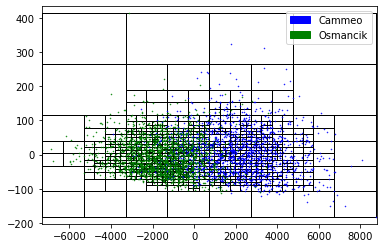

100%|██████████| 762/762 [00:01<00:00, 665.54it/s]


quad tree knn time: 1.3381302970083198s
naive knn time: 5.648991957990802s


100%|██████████| 762/762 [00:01<00:00, 583.39it/s]


quad tree knn time: 1.4109034950088244s
naive knn time: 7.374191815004451s


100%|██████████| 762/762 [00:00<00:00, 1019.68it/s]


quad tree knn time: 0.8411410789994989s
naive knn time: 6.498916662007105s


100%|██████████| 762/762 [00:00<00:00, 1048.87it/s]


quad tree knn time: 0.8247738070058404s
naive knn time: 7.371168030003901s


100%|██████████| 762/762 [00:00<00:00, 1424.17it/s]


quad tree knn time: 0.6243682940112194s
naive knn time: 5.598286458000075s
########################################
When k = 1
----------------------------------------
The confusion matrix of quad tree nearest_neighbors
[[1224  406]
 [ 414 1766]]
----------------------------------------
The confusion matrix of naive k nearest_neighbors
[[1224  406]
 [ 414 1766]]
########################################


100%|██████████| 762/762 [00:01<00:00, 444.26it/s]


quad tree knn time: 1.8051652680005645s
naive knn time: 6.058815312004299s


100%|██████████| 762/762 [00:01<00:00, 462.78it/s]


quad tree knn time: 1.7408573129941942s
naive knn time: 5.929508458997589s


100%|██████████| 762/762 [00:00<00:00, 818.27it/s]


quad tree knn time: 1.022207078000065s
naive knn time: 5.5559119829995325s


100%|██████████| 762/762 [00:00<00:00, 1261.59it/s]


quad tree knn time: 1.0766377010004362s
naive knn time: 5.133726269996259s


100%|██████████| 762/762 [00:00<00:00, 974.36it/s] 


quad tree knn time: 0.8722984730120515s
naive knn time: 5.485058051999658s
########################################
When k = 5
----------------------------------------
The confusion matrix of quad tree nearest_neighbors
[[1253  377]
 [ 313 1867]]
----------------------------------------
The confusion matrix of naive k nearest_neighbors
[[1253  377]
 [ 313 1867]]
########################################


In [41]:
import numpy as np
import math
import time
import heapq
import pandas as pd
from random import * 
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.metrics import confusion_matrix
from statistics import mode 
from tqdm import tqdm
from matplotlib.patches import Rectangle
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches

class Point:
    def __init__(self,x,y,_cls):
        self.x = x
        self.y = y
        self.cls_ = _cls
class Rect:
    def __init__(self,x,y,width,height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    def contain(self,point):
        return (point.x>=(self.x - self.width)) and (point.x <= (self.x +self.width)) and (point.y>=(self.y-self.height)) and (point.y<=(self.y + self.height))
    def within(self,point,d):
        def dist(x1,y1,x2,y2):
            return math.sqrt((x1-x2)**2+(y1-y2)**2)
        l_x = self.x - self.width
        b_y = self.y - self.height
        h_x = self.x + self.width
        t_y = self.y + self.height
        if point.x>=h_x and point.y>=t_y:
            return dist(h_x,t_y,point.x,point.y)<=d
        elif point.x>=h_x and point.y<=b_y:
            return dist(h_x,b_y,point.x,point.y)<d
        elif point.x>=h_x and point.y<t_y and point.y >b_y:
            return dist(h_x,0,point.x,0)<=d
        elif point.x<=l_x and point.y<=b_y:
            return dist(l_x,b_y,point.x,point.y)<d
        elif point.x<=l_x and point.y>=t_y:
            return dist(l_x,t_y,point.x,point.y)<d
        elif point.x<=l_x and point.y>=b_y:
            return dist(l_x,0,point.x,0)<d
        elif point.x>=l_x and point.x<=h_x and point.y>=t_y:
            return dist(0,t_y,0,point.y)<d
        elif point.x>=l_x and point.x<=h_x and point.y<=b_y:
            return dist(0,b_y,0,point.y)<d
        elif self.contain(point):
            return True
class quadTree:
    def __init__(self,boudary,points,n):
        self.boudary = boudary
        self.capacity = n
        self.isleaf = False
        self.points=points
        self.divided = False
        self.northwest = None
        self.southwest = None
        self.northeast = None
        self.southeast = None
        self.color = {"Cammeo":"ob","Osmancik":"og"}
        self.construct()
    def subdivide(self):
        x = self.boudary.x
        y = self.boudary.y
        width = self.boudary.width
        height = self.boudary.height
        ne = Rect(x + width/2,y+height/2, width/2, height/2)
        nw = Rect(x - width/2,y+height/2, width/2, height/2)
        sw = Rect(x - width/2,y-height/2, width/2, height/2)
        se = Rect(x + width/2,y-height/2, width/2, height/2)
        self.northwest = quadTree(nw,[p for p in self.points if p.x<=x and p.y>=y],self.capacity)
        self.southwest = quadTree(sw,[p for p in self.points if p.x<=x and p.y<y],self.capacity)
        self.northeast = quadTree(ne,[p for p in self.points if p.x>x and p.y>=y],self.capacity)
        self.southeast = quadTree(se,[p for p in self.points if p.x>x and p.y<y],self.capacity)
    def construct(self):
        if len(self.points)<self.capacity:
            self.isleaf = True
            return True
        else:
            if not self.divided:
                self.subdivide()
                self.divided =True
                self.points = []
    def subshow(self,ax):
        ax.add_patch( Rectangle((self.boudary.x - self.boudary.width , self.boudary.y -self.boudary.height), 
                        self.boudary.width*2, self.boudary.height*2, 
                        fc ='none', 
                        ec ='black',  
                        lw = 1))
        for i in self.points:
            ax.plot(i.x,i.y,self.color[i.cls_],markersize = .5)
        if self.divided:
            self.northeast.subshow(ax)
            self.southeast.subshow(ax)
            self.southwest.subshow(ax)
            self.northwest.subshow(ax)                
    def showfig(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)        
        self.subshow(ax)
        plt.xlim([self.boudary.x - self.boudary.width-20, self.boudary.x + self.boudary.width+20]) 
        plt.ylim([self.boudary.y - self.boudary.height-20, self.boudary.y + self.boudary.height+20])
        plt.legend(['Cammeo', 'Osmancik'])
        blue_patch = mpatches.Patch(color='blue', label='Cammeo')
        green_patch = mpatches.Patch(color='green', label='Osmancik')
        plt.legend(handles=[blue_patch, green_patch])
        plt.show()

def knn(quad,pnt,k):     
    res = []
    for p in tqdm(pnt):
        stack = [quad]
        r = (float('-inf'),"")
        pnt_ = []
        while len(stack):
            cur = stack.pop(-1)
            if cur.isleaf and cur.boudary.within(p,-r[0]):
                for i in cur.points:
                        if len(pnt_)<k:
                            heapq.heappush(pnt_,(-math.sqrt((i.x - p.x)**2+(i.y - p.y)**2),i.cls_))
                            r = heapq.nsmallest(1,pnt_)[0]
                        elif math.sqrt((i.x - p.x)**2+(i.y - p.y)**2)<-r[0]:
                            heapq.heappop(pnt_)
                            heapq.heappush(pnt_,(-math.sqrt((i.x - p.x)**2+(i.y - p.y)**2),i.cls_))
                            r = heapq.nsmallest(1,pnt_)[0]
            elif not cur.isleaf:
                if cur.boudary.within(p,-r[0]):
                    if cur.northwest:
                        stack.append(cur.northwest)
                    if cur.southeast:
                        stack.append(cur.southeast)
                    if cur.northeast:
                        stack.append(cur.northeast)
                    if cur.southwest:
                        stack.append(cur.southwest)
        res.append(mode([itr[1] for itr in pnt_]))
    return res 



    
if __name__ == '__main__':
    data = pd.read_excel('Rice_Osmancik_Cammeo_Dataset.xlsx')
    X = data.drop('CLASS', axis=1)
    y = data['CLASS']
    pca = decomposition.PCA(n_components=2)
    my_cols  = data.columns[:(len(data.columns)-1)]
    data_reduced = pca.fit_transform(data[my_cols])
    pc0 = data_reduced[:, 0]
    pc1 = data_reduced[:, 1]
    xlim_min = min(pc0)-.01
    ylim_min = min(pc1)-.01
    xlim_max = max(pc0)+.01
    ylim_max = max(pc1)+.01    
    bound = Rect((xlim_max+xlim_min)/2,(ylim_max+ylim_min)/2,(xlim_max-xlim_min)/2,(ylim_max-ylim_min)/2)
    qt = quadTree(bound,[Point(pc0[k],pc1[k],y.iloc[k]) for k in range(len(pc0))],10)
    qt.showfig()
    for k_near in [1,5]:
        kf = KFold(n_splits=5)
        res_pred = []
        res_true = []
        res_knn = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            data_reduced = pca.fit_transform(X_train[my_cols])
            test_data_reduced = pca.transform(X_test[my_cols])
            pc0 = data_reduced[:, 0]
            test_pc1 = test_data_reduced[:, 1]
            test_pc0 = test_data_reduced[:, 0]
            pc1 = data_reduced[:, 1]       
            xlim_min = min(pc0)-.01
            ylim_min = min(pc1)-.01
            xlim_max = max(pc0)+.01
            ylim_max = max(pc1)+.01

            start_time = time.perf_counter()
            bound = Rect((xlim_max+xlim_min)/2,(ylim_max+ylim_min)/2,(xlim_max-xlim_min)/2,(ylim_max-ylim_min)/2)
            qt = quadTree(bound,[Point(pc0[k],pc1[k],y_train.iloc[k]) for k in range(len(pc0))],n = 10)
            knn_res = knn(qt,[Point(test_pc0[k],test_pc1[k],y_test.iloc[k]) for k in range(len(test_pc0))],k_near)
            end_time = time.perf_counter()
            print(f"quad tree knn time: {end_time - start_time}s")

            start_time = time.perf_counter()
            y_pred = k_nearest_neighbors(list(zip(pc1,pc0,y_train)), list(zip(test_pc1,test_pc0,y_test)), k_near)
            end_time = time.perf_counter()
            print(f"naive knn time: {end_time - start_time}s")


            res_pred = res_pred + knn_res
            res_true = res_true +y_test.to_list()
            res_knn = res_knn+y_pred
        print('#'*40)    
        print('When k = '+str(k_near))
        print('-'*40)
        print('The confusion matrix of quad tree nearest_neighbors')    
        print(confusion_matrix(res_true,res_pred))
        print('-'*40)
        print('The confusion matrix of naive k nearest_neighbors') 
        print(confusion_matrix(res_true,res_knn))
        print('#'*40)